# Cell 1 — Setup and Models

**Goal.** Define the pieces used by Vanilla Policy Gradient (VPG) with Generalized Advantage Estimation (GAE).

**What’s here**
- Seeding and device selection.
- Function approximators:
  - `DiscretePolicy`: logits over actions for `gym.spaces.Discrete`.
  - `ContinuousPolicy`: Gaussian policy with learned diagonal log-std for `gym.spaces.Box`.
  - `ValueNet`: baseline $V_\theta(s)$.

**Key ideas**
- VPG optimizes $\mathbb{E}_{t}\!\left[\log \pi_\phi(a_t \mid s_t)\,\hat A_t\right]$.
- GAE advantage:
  $$
  \delta_t = r_t + \gamma V(s_{t+1}) - V(s_t), \qquad
  \hat A_t = \sum_{l=0}^{\infty} (\gamma\lambda)^l\,\delta_{t+l}.
  $$
- Continuous actions use $\mathcal{N}(\mu_\phi(s), \sigma_\phi^2)$; discrete uses `Categorical(logits)`.

**Inputs/outputs**
- Inputs: env observation dimension and action space.
- Outputs: initialized PyTorch modules on CPU/GPU.

**Tip.** Keep networks small for classic control; use wider layers for MuJoCo.


In [ ]:
"""
VPG with GAE: common imports, RNG seeding, device, and function approximators.

- DiscretePolicy: logits over discrete actions.
- ContinuousPolicy: Gaussian policy with learned log-std.
- ValueNet: state-value baseline V(s).

All modules are pure PyTorch and device-aware.
"""

import sys, time, pickle
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical, Normal
import gymnasium as gym
try:
    import gymnasium_robotics  # optional
except Exception:
    pass

# ---- seed & device ----
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---- networks ----
class DiscretePolicy(nn.Module):
    def __init__(self, state_dim: int, action_dim: int, hidden: List[int]):
        super().__init__()
        layers, in_dim = [], state_dim
        for h in hidden:
            layers += [nn.Linear(in_dim, h), nn.ReLU()]
            in_dim = h
        layers += [nn.Linear(in_dim, action_dim)]
        self.net = nn.Sequential(*layers)

    def forward(self, s: torch.Tensor):
        return self.net(s)

    def get_action(self, state_np):
        s = torch.as_tensor(state_np, dtype=torch.float32, device=device)
        logits = self.forward(s)
        dist = Categorical(logits=logits)
        a = dist.sample()
        logp = dist.log_prob(a)
        return int(a.item()), logp

class ContinuousPolicy(nn.Module):
    def __init__(self, state_dim: int, action_dim: int, hidden: List[int]):
        super().__init__()
        layers, in_dim = [], state_dim
        for h in hidden:
            layers += [nn.Linear(in_dim, h), nn.ReLU()]
            in_dim = h
        self.mean = nn.Sequential(*layers, nn.Linear(in_dim, action_dim))
        self.log_std = nn.Parameter(torch.zeros(action_dim))

    def forward(self, s: torch.Tensor):
        mu = self.mean(s)
        std = self.log_std.exp()
        return mu, std

    def get_action(self, state_np):
        s = torch.as_tensor(state_np, dtype=torch.float32, device=device)
        mu, std = self.forward(s)
        dist = Normal(mu, std)
        a = dist.sample()
        logp = dist.log_prob(a).sum(-1)
        return a.detach().cpu().numpy(), logp

class ValueNet(nn.Module):
    def __init__(self, state_dim: int, hidden: List[int]):
        super().__init__()
        layers, in_dim = [], state_dim
        for h in hidden:
            layers += [nn.Linear(in_dim, h), nn.ReLU()]
            in_dim = h
        layers += [nn.Linear(in_dim, 1)]
        self.net = nn.Sequential(*layers)

    def forward(self, s: torch.Tensor):
        return self.net(s).squeeze(-1)

Device: cpu


# Cell 2 — Agent (VPG + GAE)

**Goal.** Implement the learning agent that collects trajectories, computes GAE, and updates policy/value.

**Flow per episode**
1. Roll out one episode and store `(s_t, a_t, r_t, done_t, logπ_t)`.
2. Compute values $V(s_t)$ and advantages $\hat{A}_t$ via GAE $(\gamma,\lambda)$.
3. Update policy and value with the losses below, then clear buffers.

**Policy loss**

$$
\mathcal{L}_{\text{policy}} = -\mathbb{E}_{t}\!\left[\log \pi_{\phi}(a_t \mid s_t)\,\hat{A}_t\right]
$$

**Value loss**

$$
\mathcal{L}_{\text{value}} =
\Big\|V_{\theta}(s_t) - \big(\hat{A}_t + V(s_t)\big)\Big\|_2^2
$$

**Interfaces**
- `select_action(state, action_space)` → env-ready action; records log-prob.
- `store(r, done)` → appends reward and termination flag.
- `update()` → performs both gradient steps and resets buffers.

In [ ]:
"""
VPGAgentWithGAE:

- Collects one full episode of (s, a, r, done, logπ) tuples.
- Computes GAE(γ, λ) advantages.
- Performs one policy gradient step and one value regression step.
- Supports both discrete and continuous Gymnasium action spaces.
"""
class VPGAgentWithGAE:
    def __init__(self, state_dim: int, action_space, lr_policy=1e-3, lr_value=1e-3,
                 gamma=0.99, lam=0.95, hidden_pi=None, hidden_v=None):
        self.gamma = gamma
        self.lam = lam
        self.is_cont = isinstance(action_space, gym.spaces.Box)
        if hidden_pi is None: hidden_pi = [64, 64]
        if hidden_v  is None: hidden_v  = [64, 64]

        if self.is_cont:
            self.policy = ContinuousPolicy(state_dim, int(np.prod(action_space.shape)), hidden_pi).to(device)
            self.act_low  = torch.as_tensor(action_space.low,  dtype=torch.float32)
            self.act_high = torch.as_tensor(action_space.high, dtype=torch.float32)
        else:
            self.policy = DiscretePolicy(state_dim, action_space.n, hidden_pi).to(device)

        self.value_net = ValueNet(state_dim, hidden_v).to(device)
        self.pi_opt = optim.Adam(self.policy.parameters(), lr=lr_policy)
        self.vf_opt = optim.Adam(self.value_net.parameters(), lr=lr_value)
        self.reset_traj()

    def reset_traj(self):
        self.states, self.actions, self.rewards, self.dones, self.logps = [], [], [], [], []

    def select_action(self, state, action_space):
        a, logp = self.policy.get_action(state)
        if self.is_cont:
            a = np.clip(a, action_space.low, action_space.high)
        self.states.append(np.array(state, dtype=np.float32))
        self.actions.append(a if self.is_cont else int(a))
        self.logps.append(logp)
        return a

    def store(self, r, done):
        self.rewards.append(float(r))
        self.dones.append(1 if done else 0)

    def compute_gae(self, rewards, values, dones):
        adv, gae = [], 0.0
        for t in reversed(range(len(rewards))):
            next_v = 0.0 if t == len(rewards)-1 else values[t+1]
            next_d = 1.0 if t == len(rewards)-1 else dones[t+1]
            delta = rewards[t] + self.gamma * next_v * (1 - next_d) - values[t]
            gae = delta + self.gamma * self.lam * (1 - next_d) * gae
            adv.insert(0, gae)
        return np.array(adv, dtype=np.float32)

    def update(self):
        s = torch.as_tensor(np.array(self.states, dtype=np.float32), device=device)
        with torch.no_grad():
            v_np = self.value_net(s).detach().cpu().numpy()
        adv = self.compute_gae(self.rewards, v_np, self.dones)
        ret = adv + v_np
        adv_t = torch.as_tensor((adv - adv.mean()) / (adv.std() + 1e-8), device=device)
        ret_t = torch.as_tensor(ret, device=device)

        # policy loss
        logp_t = torch.stack(self.logps).to(device)
        pi_loss = -(logp_t * adv_t).mean()
        self.pi_opt.zero_grad(); pi_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 0.5)
        self.pi_opt.step()

        # value loss
        v_pred = self.value_net(s)
        vf_loss = nn.MSELoss()(v_pred, ret_t)
        self.vf_opt.zero_grad(); vf_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.value_net.parameters(), 0.5)
        self.vf_opt.step()

        self.reset_traj()
        return float(pi_loss.item()), float(vf_loss.item())


# Cell 3 — Train, Evaluate, Plot

**Goal.** High-level utilities to run experiments and visualize learning.

**Functions**
- `train_vpg_gae(env_name, ...)`
  - Loops over episodes.
  - Step: sample action from policy → `env.step(a)` → store `(r, done)`.
  - End of episode: `agent.update()` (policy gradient + value MSE).
  - Logs per-episode return and Moving Avg over last 100 episodes.
- `evaluate_agent(agent, env_name, ...)`
  - Runs multiple **stochastic** rollouts (sampled actions).
  - Returns mean ± std of undiscounted episode returns.
  - For deterministic eval: use argmax (discrete) or mean action (continuous).
- `plot_single_env_results(...)`
  - Plots raw episode returns, Moving Avg(100), and a horizontal Eval(mean) line.
- `print_single_env_summary(...)`
  - Prints training time, final Moving Avg(100), and Eval mean ± std.

**Metrics**
- **Episode Reward:** sum of rewards in one episode.
- **Moving Avg(100):** smooth training curve.
- **Eval Mean ± Std:** post-training score over N eval episodes.

**Reproducibility**
- Global `seed` drives NumPy, PyTorch, and `env.reset(seed=seed+episode)`.
- Hardware/driver differences can introduce small variation.

**Knobs to tune**
- `num_episodes`, `max_steps`
- `lr_policy`, `lr_value`
- `gamma`, `lam`
- `hidden_pi`, `hidden_v`
- `print_freq`, eval episodes for tighter confidence.

**Outputs**
- Trained `agent`, `episode_rewards`, `moving_avg`, total training seconds.
- Saved plot (if `save_path` given).

In [ ]:
"""
High-level helpers:

- train_vpg_gae: episode-by-episode training loop.
- evaluate_agent: run multiple evaluation episodes.
- plot_single_env_results: visualize per-episode returns, moving average, and Eval(mean).
- print_single_env_summary: plain-text summary for reports.
"""
def train_vpg_gae(env_name: str,
                  num_episodes: int = 1000,
                  lr_policy: float = 1e-3,
                  lr_value: float = 1e-3,
                  gamma: float = 0.99,
                  lam: float = 0.95,
                  hidden_pi: List[int] = None,
                  hidden_v:  List[int] = None,
                  print_freq: int = 50,
                  max_steps: int = 1000):
    env = gym.make(env_name)
    state_dim = int(np.prod(env.observation_space.shape))
    agent = VPGAgentWithGAE(state_dim, env.action_space, lr_policy, lr_value, gamma, lam, hidden_pi, hidden_v)

    ep_rewards, mov_avg = [], []
    t0 = time.time()

    for ep in range(num_episodes):
        state, _ = env.reset(seed=seed + ep)
        ep_ret = 0.0
        for t in range(max_steps):
            a = agent.select_action(state, env.action_space)
            ns, r, term, trunc, _ = env.step(a)
            done = bool(term or trunc)
            agent.store(r, done)
            ep_ret += r
            state = ns
            if done: break

        pi_l, vf_l = agent.update()
        ep_rewards.append(ep_ret)
        mov_avg.append(np.mean(ep_rewards[-100:]))

        if (ep+1) % print_freq == 0:
            print(f"Ep {ep+1}/{num_episodes} | Ret {ep_ret:.1f} | Avg100 {mov_avg[-1]:.1f} | "
                  f"Pi {pi_l:.4f} | Vf {vf_l:.4f} | {time.time()-t0:.1f}s")

    env.close()
    return agent, ep_rewards, mov_avg, time.time()-t0

# ---- evaluation ----
def evaluate_agent(agent: VPGAgentWithGAE, env_name: str, num_episodes: int = 20, max_steps: int = 1000):
    env = gym.make(env_name)
    rs = []
    for ep in range(num_episodes):
        s, _ = env.reset()
        ep_r = 0.0
        for t in range(max_steps):
            with torch.no_grad():
                a, _ = agent.policy.get_action(s)  # stochastic eval; switch to mean for deterministic
            if agent.is_cont:
                a = np.clip(a, env.action_space.low, env.action_space.high)
            s, r, term, trunc, _ = env.step(a)
            ep_r += r
            if term or trunc: break
        rs.append(ep_r)
    env.close()
    return float(np.mean(rs)), float(np.std(rs))

# ---- plot ----
def plot_single_env_results(env_name: str, ep_rewards: List[float], mov_avg: List[float],
                            eval_mean: float, eval_std: float, save_path: str = None):
    eps = np.arange(1, len(ep_rewards)+1)
    plt.figure(figsize=(10,6))
    plt.plot(eps, ep_rewards, alpha=0.3, label="Episode Reward")
    plt.plot(eps, mov_avg, lw=2, label="Moving Avg (100)")
    plt.axhline(eval_mean, ls="--", c="g", lw=2, label=f"Eval Mean: {eval_mean:.2f} ± {eval_std:.2f}")
    plt.xlabel("Episode"); plt.ylabel("Reward"); plt.title(f"VPG+GAE — {env_name}")
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print("Saved plot:", save_path)
    plt.show()

# ---- summary print ----
def print_single_env_summary(env_name: str, final_avg: float, eval_mean: float, eval_std: float, train_time: float):
    print("\n" + "="*80)
    print(f"RESULTS SUMMARY — {env_name}")
    print("="*80)
    print(f"Training Time:            {train_time:.1f}s")
    print(f"Final Training Avg(100):  {final_avg:.2f}")
    print(f"Evaluation Mean ± Std:    {eval_mean:.2f} ± {eval_std:.2f}")
    print("="*80 + "\n")

In [ ]:
# Cell 1 — system deps
!apt-get -y update && apt-get -y install swig
# Cell 2 — Python deps
%pip -q install --upgrade pip setuptools wheel
%pip -q install "gymnasium[classic-control,box2d,mujoco]" mujoco pygame imageio[ffmpeg]

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:3 https://cli.github.com/packages stable InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,077 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,425 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,276 kB]
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,352 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 https://ppa.launchpadcontent.net/deadsnakes/ppa/

# CartPole-v1

Ep 50/2000 | Ret 17.0 | Avg100 29.6 | Pi 0.0336 | Vf 39.0417 | 1.7s
Ep 100/2000 | Ret 22.0 | Avg100 32.5 | Pi -0.0674 | Vf 37.0722 | 3.6s
Ep 150/2000 | Ret 181.0 | Avg100 41.3 | Pi -0.0038 | Vf 344.1514 | 6.2s
Ep 200/2000 | Ret 104.0 | Avg100 62.9 | Pi 0.0239 | Vf 306.2456 | 10.8s
Ep 250/2000 | Ret 286.0 | Avg100 125.8 | Pi 0.0117 | Vf 272.2020 | 19.4s
Ep 300/2000 | Ret 227.0 | Avg100 213.6 | Pi 0.0126 | Vf 192.4909 | 32.5s
Ep 350/2000 | Ret 66.0 | Avg100 234.0 | Pi 0.0629 | Vf 647.9867 | 43.1s
Ep 400/2000 | Ret 328.0 | Avg100 194.5 | Pi 0.0105 | Vf 86.5984 | 52.3s
Ep 450/2000 | Ret 500.0 | Avg100 249.4 | Pi -0.0051 | Vf 174.1182 | 68.5s
Ep 500/2000 | Ret 239.0 | Avg100 283.5 | Pi 0.0113 | Vf 48.0551 | 80.9s
Ep 550/2000 | Ret 297.0 | Avg100 333.9 | Pi -0.0055 | Vf 328.0721 | 102.8s
Ep 600/2000 | Ret 263.0 | Avg100 446.3 | Pi -0.0115 | Vf 353.9419 | 126.5s
Ep 650/2000 | Ret 438.0 | Avg100 454.5 | Pi 0.0003 | Vf 44.9072 | 148.6s
Ep 700/2000 | Ret 500.0 | Avg100 446.6 | Pi 0.0106 | Vf 80.

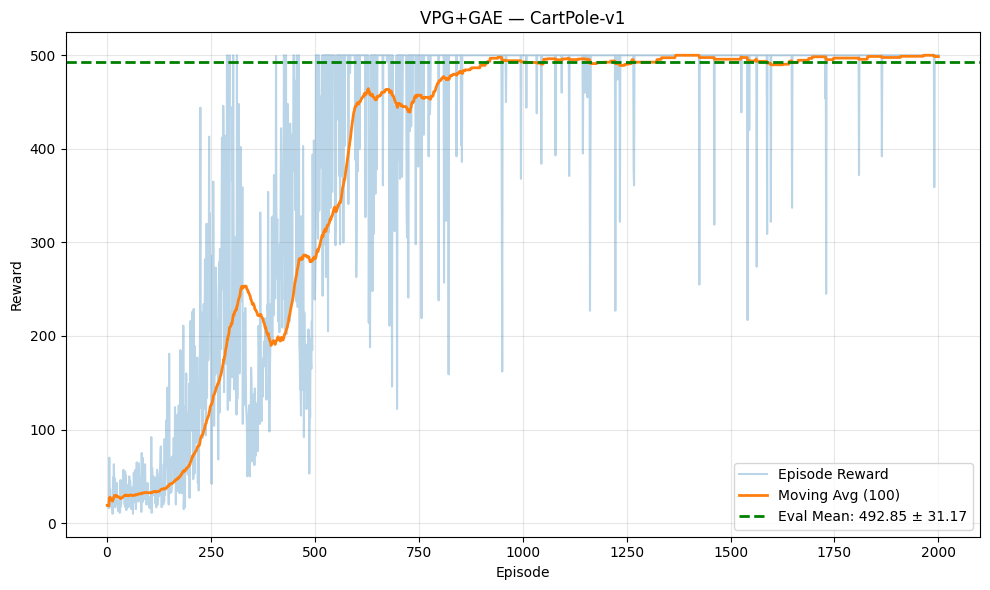


RESULTS SUMMARY — CartPole-v1
Training Time:            813.5s
Final Training Avg(100):  498.59
Evaluation Mean ± Std:    492.85 ± 31.17



In [ ]:
if __name__ == "__main__":
    env_id = "CartPole-v1"
    agent, ep_rewards, mov_avg, tsec = train_vpg_gae(env_id, num_episodes=2000, lr_policy=5e-4, lr_value=1e-3,
                                                     gamma=0.99, lam=0.97, hidden_pi=[128,128], hidden_v=[64,64],
                                                     max_steps=500, print_freq=50)
    eval_mean, eval_std = evaluate_agent(agent, env_id, num_episodes=20, max_steps=500)
    plot_single_env_results(env_id, ep_rewards, mov_avg, eval_mean, eval_std, save_path=f"{env_id}_vpg_training.png")
    print_single_env_summary(env_id, mov_avg[-1], eval_mean, eval_std, tsec)

# Acrobot-v1

Ep 200/10000 | Ret -65.0 | Avg100 -173.1 | Pi -0.0145 | Vf 51.7376 | 64.1s
Ep 400/10000 | Ret -70.0 | Avg100 -86.2 | Pi -0.0464 | Vf 18.4943 | 89.2s
Ep 600/10000 | Ret -73.0 | Avg100 -81.7 | Pi -0.0008 | Vf 17.3546 | 111.2s
Ep 800/10000 | Ret -76.0 | Avg100 -80.2 | Pi -0.0259 | Vf 3.2465 | 134.1s
Ep 1000/10000 | Ret -78.0 | Avg100 -83.9 | Pi -0.0013 | Vf 3.0071 | 157.6s
Ep 1200/10000 | Ret -77.0 | Avg100 -89.5 | Pi 0.0039 | Vf 6.6452 | 182.3s
Ep 1400/10000 | Ret -83.0 | Avg100 -85.3 | Pi 0.0002 | Vf 5.1324 | 205.8s
Ep 1600/10000 | Ret -72.0 | Avg100 -81.2 | Pi -0.0134 | Vf 5.2742 | 229.2s
Ep 1800/10000 | Ret -79.0 | Avg100 -83.7 | Pi -0.0008 | Vf 6.1748 | 252.4s
Ep 2000/10000 | Ret -76.0 | Avg100 -82.9 | Pi -0.0153 | Vf 3.3977 | 275.4s
Ep 2200/10000 | Ret -128.0 | Avg100 -81.5 | Pi 0.0035 | Vf 113.9913 | 298.4s
Ep 2400/10000 | Ret -72.0 | Avg100 -84.9 | Pi -0.0022 | Vf 14.5148 | 322.3s
Ep 2600/10000 | Ret -94.0 | Avg100 -80.2 | Pi -0.0017 | Vf 19.0219 | 345.8s
Ep 2800/10000 | Ret -63.0

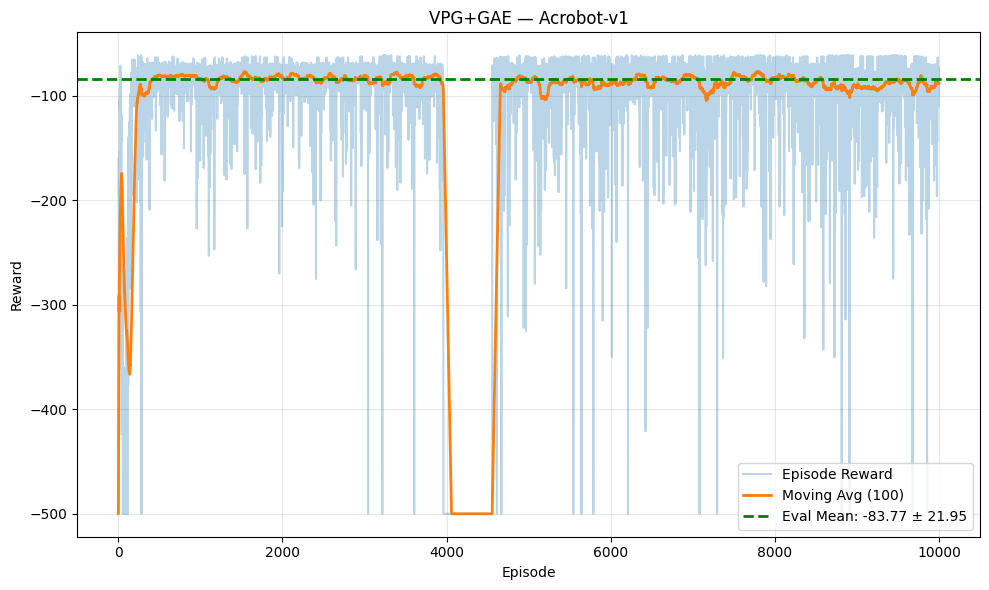

Saved plot: Acrobot-v1_vpg_training.png


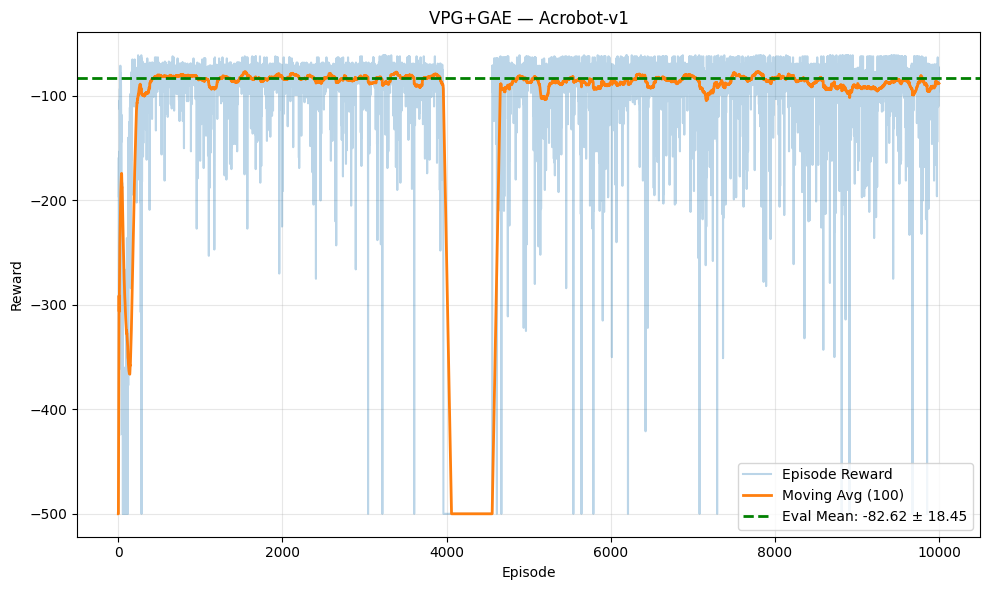


RESULTS SUMMARY — Acrobot-v1
Training Time:            1547.8s
Final Training Avg(100):  -88.00
Evaluation Mean ± Std:    -82.62 ± 18.45



In [ ]:
# VPG+GAE on ACROBOT
env_id = "Acrobot-v1"
agent, ep_rewards, mov_avg, tsec = train_vpg_gae(
    env_id,
    num_episodes=10_000,
    lr_policy=3e-3, lr_value=1e-3,
    gamma=0.99, lam=0.97,
    hidden_pi=[256,256], hidden_v=[256,256],
    max_steps=500, print_freq=200
)
eval_mean, eval_std = evaluate_agent(agent, env_id, num_episodes=100, max_steps=500)
plot_single_env_results(env_id, ep_rewards, mov_avg, eval_mean, eval_std, save_path=f"{env_id}_vpg_training.png")


print_single_env_summary(env_id, mov_avg[-1], eval_mean, eval_std, tsec)


# InvertedPendulum-v5

Ep 100/3000 | Ret 5.0 | Avg100 13.0 | Pi -0.1049 | Vf 27.8780 | 2.4s
Ep 200/3000 | Ret 53.0 | Avg100 41.2 | Pi 0.0308 | Vf 155.8943 | 7.5s
Ep 300/3000 | Ret 55.0 | Avg100 77.1 | Pi -0.1955 | Vf 255.4840 | 18.1s
Ep 400/3000 | Ret 118.0 | Avg100 102.0 | Pi -0.0390 | Vf 129.3907 | 30.4s
Ep 500/3000 | Ret 218.0 | Avg100 126.3 | Pi -0.1015 | Vf 420.5445 | 45.3s
Ep 600/3000 | Ret 353.0 | Avg100 330.0 | Pi 0.0254 | Vf 266.4204 | 83.8s
Ep 700/3000 | Ret 1000.0 | Avg100 802.3 | Pi 0.0019 | Vf 413.7218 | 176.5s
Ep 800/3000 | Ret 1000.0 | Avg100 947.0 | Pi -0.0113 | Vf 407.8521 | 285.6s
Ep 900/3000 | Ret 1000.0 | Avg100 877.2 | Pi -0.0038 | Vf 421.4828 | 386.9s
Ep 1000/3000 | Ret 1000.0 | Avg100 915.3 | Pi -0.0209 | Vf 421.9909 | 492.9s
Ep 1100/3000 | Ret 729.0 | Avg100 967.2 | Pi -0.0499 | Vf 566.2529 | 604.2s
Ep 1200/3000 | Ret 1000.0 | Avg100 991.0 | Pi 0.0202 | Vf 420.4130 | 718.8s
Ep 1300/3000 | Ret 1000.0 | Avg100 933.9 | Pi 0.0338 | Vf 413.5284 | 827.2s
Ep 1400/3000 | Ret 1000.0 | Avg100 9

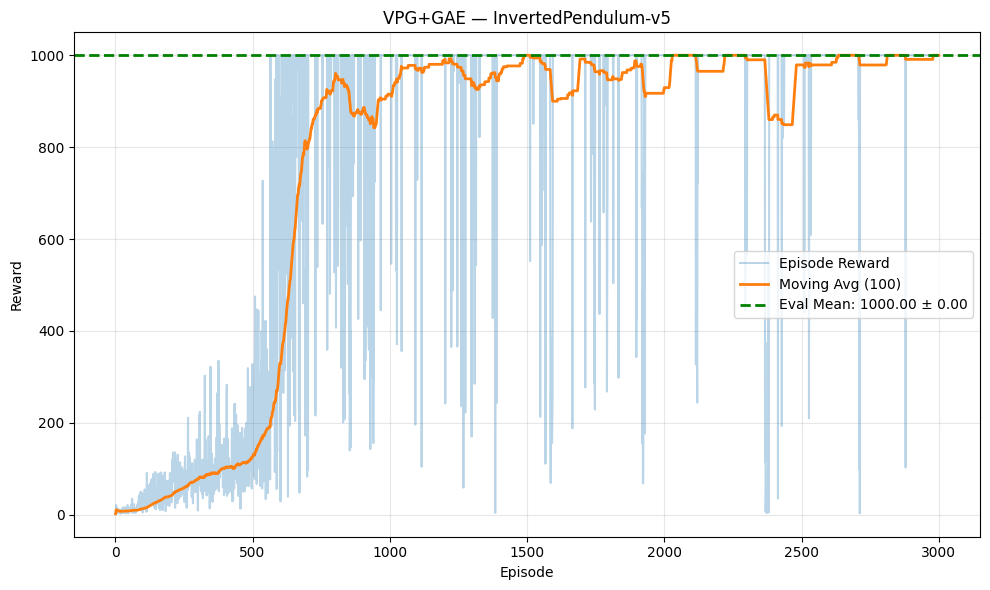


RESULTS SUMMARY — InvertedPendulum-v5
Training Time:            2725.8s
Final Training Avg(100):  1000.00
Evaluation Mean ± Std:    1000.00 ± 0.00



In [ ]:
# INVERTED-PENDULUM — VPG+GAE (MuJoCo)
env_id = "InvertedPendulum-v5"
agent, ep_rewards, mov_avg, tsec = train_vpg_gae(
    env_id,
    num_episodes=3000,
    lr_policy=3e-4, lr_value=1e-3,
    gamma=0.995, lam=0.97,
    hidden_pi=[256,256], hidden_v=[256,256],
    max_steps=1000, print_freq=100
)
eval_mean, eval_std = evaluate_agent(agent, env_id, num_episodes=20, max_steps=1000)
plot_single_env_results(env_id, ep_rewards, mov_avg, eval_mean, eval_std,
                        save_path=f"{env_id}_vpg_training.png")
print_single_env_summary(env_id, mov_avg[-1], eval_mean, eval_std, tsec)


# HalfCheetah-v5

Ep 100/5000 | Ret -115.8 | Avg100 -174.0 | Pi 0.0365 | Vf 75.9403 | 145.9s
Ep 200/5000 | Ret 369.5 | Avg100 3.4 | Pi -0.0490 | Vf 178.0243 | 292.2s
Ep 300/5000 | Ret 554.5 | Avg100 387.6 | Pi 0.0203 | Vf 315.4446 | 439.6s
Ep 400/5000 | Ret 941.8 | Avg100 713.7 | Pi 0.0386 | Vf 902.5436 | 584.0s
Ep 500/5000 | Ret 1168.8 | Avg100 992.0 | Pi 0.0376 | Vf 1322.9821 | 729.9s
Ep 600/5000 | Ret 1420.8 | Avg100 1209.5 | Pi 0.0629 | Vf 1915.1100 | 874.7s
Ep 700/5000 | Ret 1412.7 | Avg100 1286.6 | Pi -0.0529 | Vf 1893.3446 | 1020.4s
Ep 800/5000 | Ret 1370.9 | Avg100 1324.6 | Pi 0.0851 | Vf 1713.2212 | 1165.8s
Ep 900/5000 | Ret 1198.6 | Avg100 1373.5 | Pi 0.0861 | Vf 1317.9990 | 1311.1s
Ep 1000/5000 | Ret 1343.3 | Avg100 1352.0 | Pi -0.0495 | Vf 1659.3593 | 1456.4s
Ep 1100/5000 | Ret 1515.7 | Avg100 1406.6 | Pi -0.0310 | Vf 2092.1702 | 1601.9s
Ep 1200/5000 | Ret 1452.5 | Avg100 1411.3 | Pi 0.0339 | Vf 1910.1718 | 1747.0s
Ep 1300/5000 | Ret 1342.0 | Avg100 1426.7 | Pi 0.0004 | Vf 1690.4296 | 1892.4

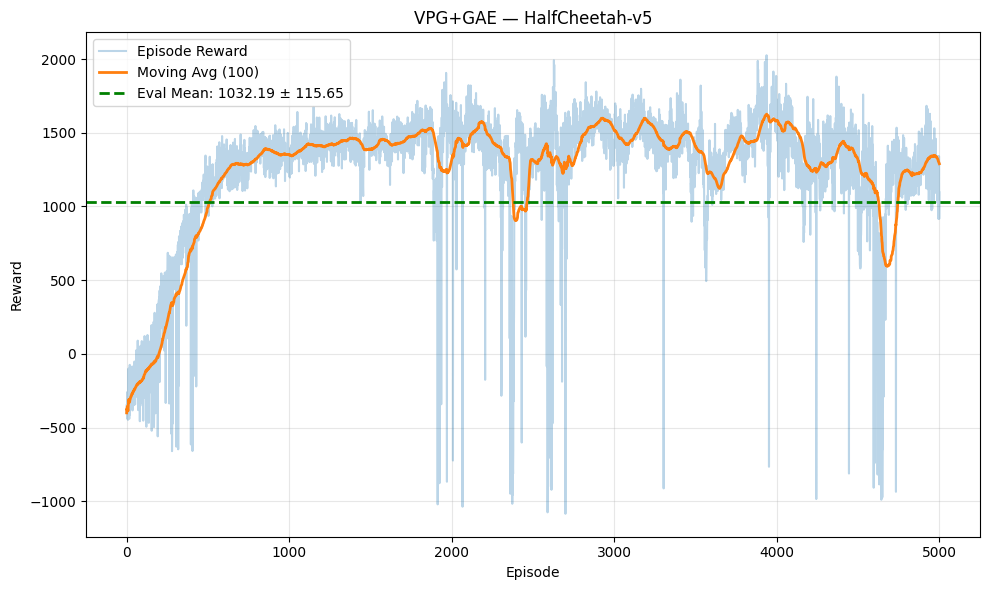


RESULTS SUMMARY — HalfCheetah-v5
Training Time:            7262.7s
Final Training Avg(100):  1289.48
Evaluation Mean ± Std:    1032.19 ± 115.65



In [ ]:
# HALF-CHEETAH — VPG+GAE (continuous)
env_id = "HalfCheetah-v5"
agent, ep_rewards, mov_avg, tsec = train_vpg_gae(
    env_id,
    num_episodes=5000,           # increase if learning is slow
    lr_policy=3e-4, lr_value=3e-3,
    gamma=0.997, lam=0.97,
    hidden_pi=[256,256], hidden_v=[256,256],
    max_steps=1000, print_freq=100
)
eval_mean, eval_std = evaluate_agent(agent, env_id, num_episodes=20, max_steps=1000)
plot_single_env_results(env_id, ep_rewards, mov_avg, eval_mean, eval_std,
                        save_path=f"{env_id}_vpg_training.png")
print_single_env_summary(env_id, mov_avg[-1], eval_mean, eval_std, tsec)


# LunarLander-v3

/usr/local/lib/python3.12/dist-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


Ep 200/4000 | Ret -183.3 | Avg100 -152.7 | Pi -0.0424 | Vf 260.2877 | 21.2s
Ep 400/4000 | Ret -119.7 | Avg100 -123.1 | Pi -0.0434 | Vf 332.8530 | 49.6s
Ep 600/4000 | Ret -76.5 | Avg100 -59.6 | Pi -0.0552 | Vf 55.3829 | 83.1s
Ep 800/4000 | Ret -11.7 | Avg100 -14.3 | Pi 0.0118 | Vf 168.2178 | 126.5s
Ep 1000/4000 | Ret -3.1 | Avg100 -16.8 | Pi -0.0586 | Vf 104.7886 | 195.1s
Ep 1200/4000 | Ret -40.9 | Avg100 -13.7 | Pi -0.0806 | Vf 146.4092 | 282.6s
Ep 1400/4000 | Ret -19.9 | Avg100 28.7 | Pi -0.1679 | Vf 83.9412 | 395.5s
Ep 1600/4000 | Ret 5.2 | Avg100 51.1 | Pi 0.0192 | Vf 74.1384 | 542.6s
Ep 1800/4000 | Ret 64.4 | Avg100 72.8 | Pi -0.0563 | Vf 8.3999 | 692.1s
Ep 2000/4000 | Ret -57.8 | Avg100 65.4 | Pi 0.0505 | Vf 100.2966 | 841.2s
Ep 2200/4000 | Ret 83.2 | Avg100 80.1 | Pi -0.0957 | Vf 3.9652 | 989.1s
Ep 2400/4000 | Ret 35.2 | Avg100 78.5 | Pi 0.0179 | Vf 25.2252 | 1137.2s
Ep 2600/4000 | Ret 134.8 | Avg100 59.0 | Pi -0.0302 | Vf 12.0044 | 1267.5s
Ep 2800/4000 | Ret -20.9 | Avg100 71.7 

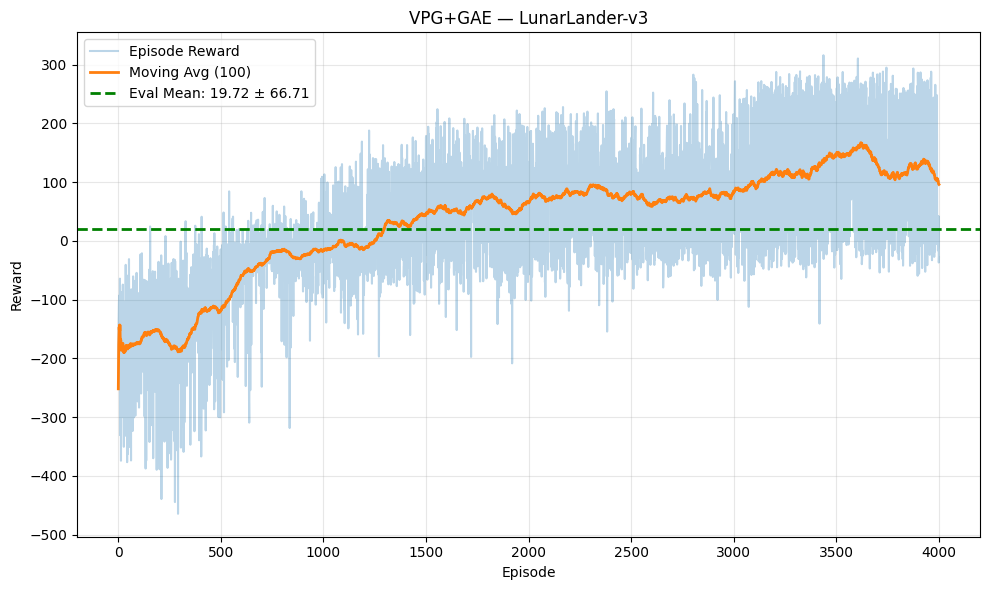


RESULTS SUMMARY — LunarLander-v3
Training Time:            1932.9s
Final Training Avg(100):  96.05
Evaluation Mean ± Std:    19.72 ± 66.71



In [ ]:
# LUNAR LANDER — VPG+GAE (discrete)
env_id = "LunarLander-v3"
agent, ep_rewards, mov_avg, tsec = train_vpg_gae(
    env_id,
    num_episodes=4_000,
    lr_policy=3e-4, lr_value=1e-3,
    gamma=0.99, lam=0.95,
    hidden_pi=[128,128], hidden_v=[128,128],
    max_steps=1_000, print_freq=200
)
eval_mean, eval_std = evaluate_agent(agent, env_id, num_episodes=50, max_steps=1_000)
plot_single_env_results(env_id, ep_rewards, mov_avg, eval_mean, eval_std,
                        save_path=f"{env_id}_vpg_training.png")
print_single_env_summary(env_id, mov_avg[-1], eval_mean, eval_std, tsec)
